In [1]:
import numpy as np
import matplotlib.pyplot as plt
from esmda import ES 

## STEP 1 - define required functions

In [2]:
## define toy forward model (X -> f(X) = 3*X[0]-X[1]+2)
def forward(X: np.ndarray) -> np.ndarray:
    f = 3*X[:,0] - X[:,1] + 2
    return f

one_of_truth = np.array([-1,-1]).reshape(1,2)
def get_observation(X:np.ndarray=one_of_truth, 
                    mesaurement_error:float = 0.02) -> np.ndarray:
    obs = forward(X) + np.random.normal(0,mesaurement_error)
    return obs

## STEP 2 - how ground truth looks like

Text(0.5, 1.0, 'groud truth assemblement')

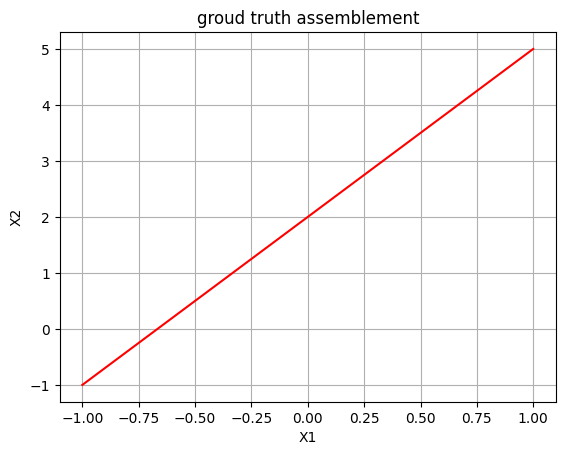

In [51]:
# make ground truth case
x_1 = np.linspace(-1,1,100)
x_2 = 3*x_1 + 2 
plt.plot(x_1, x_2, '-r')
plt.grid('equal')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('groud truth assemblement')

## STEP 3 - generate ensemble

shape of ensemble = (100, 2)


Text(0.5, 0, 'X2')

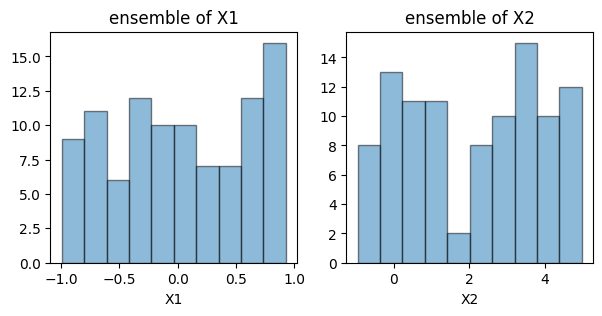

In [32]:
# make ensemble 
num_of_ensemble = 100
range_of_x_1 = [-1, 1]
range_of_x_2 = [-1, 5]

ensemble = []
for i in range(num_of_ensemble):
    X_1s = np.random.uniform(low = range_of_x_1[0],high = range_of_x_1[1])
    X_2s = np.random.uniform(low = range_of_x_2[0],high = range_of_x_2[1])
    ensemble.append([X_1s, X_2s])

ensemble = np.array(ensemble)
print(f'shape of ensemble = {ensemble.shape}')

plt.figure(figsize = (7,3))

plt.subplot(1,2,1)
plt.hist(ensemble[:,0], edgecolor = 'k', alpha = 0.5)
plt.title('ensemble of X1')
plt.xlabel('X1')

plt.subplot(1,2,2)
plt.hist(ensemble[:,1], edgecolor = 'k', alpha = 0.5)
plt.title('ensemble of X2')
plt.xlabel('X2')

## STEP 4 - check ES then run ES-MDA

In [33]:
?ES

Signature:
ES(
    OBS,
    static,
    dynamic,
    alpha=1,
    stdErrOfDynamic_percentage=0.05,
    add_noise=False,
)
Docstring:
Ensemble Smoother function that assimilates observations into an ensemble.

Parameters:
OBS (numpy.ndarray): Array of observations.
static (numpy.ndarray): Array of static variables. should be provided (number of ensemble x number of static variables).
dynamic (numpy.ndarray): Array of dynamic variables. should be provided (number of ensemble x number of dynamic variables).
alpha (float): Smoothing factor (default is 1).
stdErrOfDynamic (float): Standard error of dynamic variables (default is 0.1).
add_noise (bool): Add noise to dynamic variables (default is False).

Returns:
numpy.ndarray: Array of updated static variables.
File:      c:\100_research\esmda-quick-demo\esmda.py
Type:      function

In [43]:
## run esmda
# set up the hyperparameters
num_of_iteration = 10
stdErrOfDynamic_percentage = 0.05
alpha = [20 for i in range(num_of_ensemble)]
ground_truth_OBS_with_noise = np.array(get_observation()).reshape(-1,1)

# record the initial ensemble
ensemble_by_iteration = [ensemble]

# start of iteration
for iter in range(num_of_iteration):
    # get my current ensemble
    ensemble_static = ensemble_by_iteration[-1]

    # make prediction of ensemble
    ensemble_dynamic = forward(ensemble_static)
    
    # assimilate ensemble
    updated_ensemble = ES(OBS = ground_truth_OBS_with_noise, 
                          static = ensemble_static, 
                          dynamic = ensemble_dynamic,
                          alpha = alpha[iter],
                          stdErrOfDynamic_percentage = stdErrOfDynamic_percentage,)
    

    # in case updated value exceed the range
    flag = updated_ensemble[:,0] < range_of_x_1[0]
    updated_ensemble[flag, 0] = range_of_x_1[0]
    flag = updated_ensemble[:,0] > range_of_x_1[1]
    updated_ensemble[flag, 0] = range_of_x_1[1]
    flag = updated_ensemble[:,1] < range_of_x_2[0]
    updated_ensemble[flag, 1] = range_of_x_2[0]
    flag = updated_ensemble[:,1] > range_of_x_2[1]
    updated_ensemble[flag, 1] = range_of_x_2[1]

    # record the updated ensemble before going to next iteration
    ensemble_by_iteration.append(updated_ensemble)

## STEP 5 - visualize results

Text(0, 0.5, 'X2')

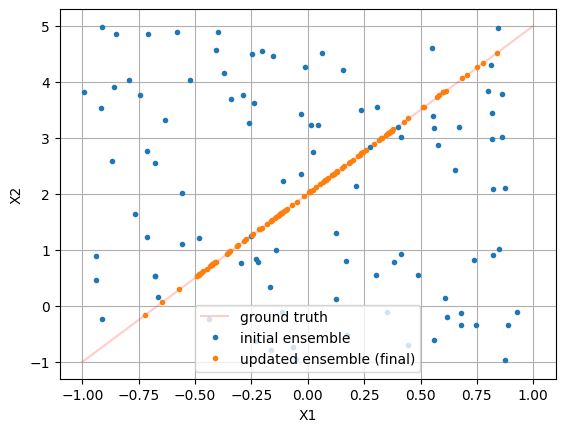

In [53]:
# visual - initial vs. final ensemble comparison
initial_ensemble = ensemble_by_iteration[0]
final_ensemble = ensemble_by_iteration[-1]

plt.plot(x_1, x_2, '-r', label = 'ground truth', alpha = 0.2)
plt.plot(initial_ensemble[:,0], initial_ensemble[:,1], '.', label = 'initial ensemble')
plt.plot(final_ensemble[:,0], final_ensemble[:,1], '.', label = 'updated ensemble (final)')
plt.grid('equal')
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')

Text(0, 0.5, 'X2')

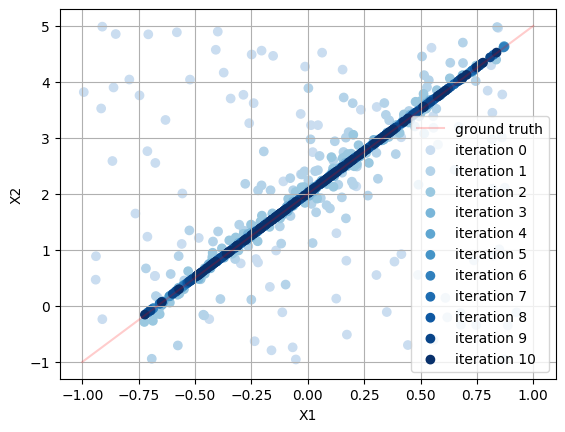

In [57]:
# visual - ensemble update progress
plt.plot(x_1, x_2, '-r', label = 'ground truth', alpha = 0.2)
for i, ensemble in enumerate(ensemble_by_iteration):
    plt.scatter(ensemble[:,0], ensemble[:,1], c=np.ones_like(ensemble[:,0])*i + 3,
                vmin = 0, vmax = num_of_iteration + 3, 
                label = f'iteration {i}', cmap = 'Blues')
plt.grid('equal')
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')

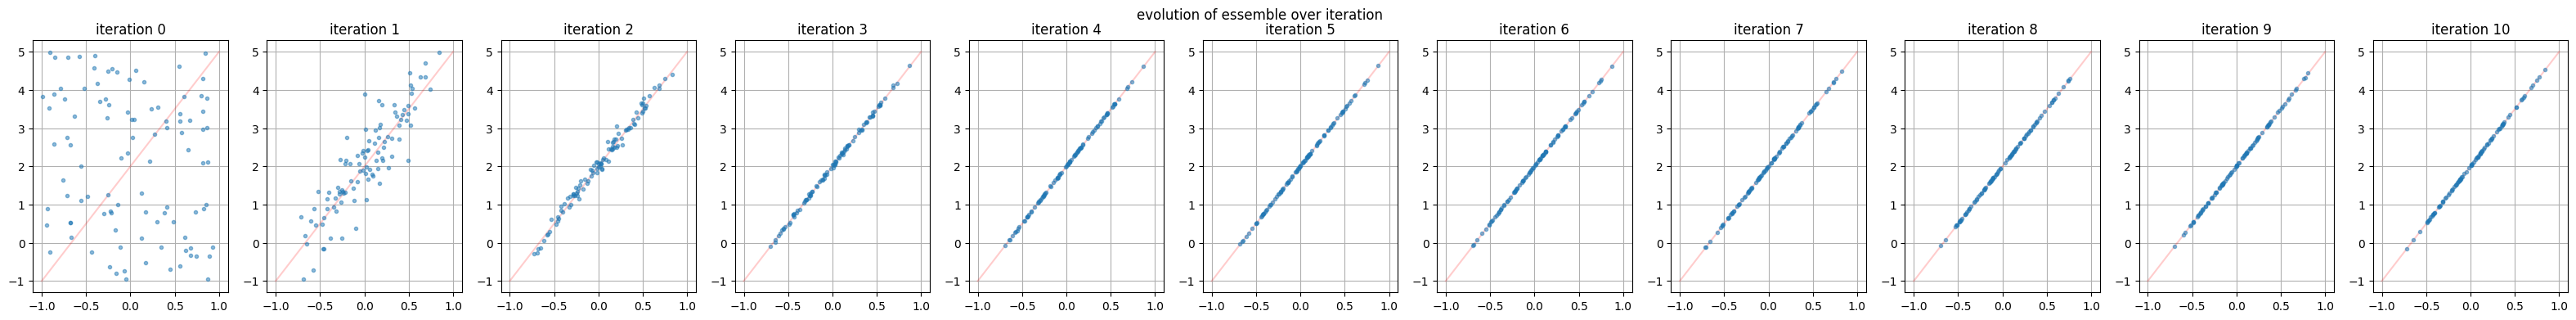

In [67]:
# visual - ensemble update progress
plt.figure(figsize = (40,4))
plt.suptitle('evolution of essemble over iteration')
for i, ensemble in enumerate(ensemble_by_iteration, 1):
    plt.subplot(1,11,i)
    plt.title(f'iteration {i-1}')
    plt.plot(x_1, x_2, '-r', alpha = 0.2)
    plt.plot(ensemble[:,0], ensemble[:,1],'.', alpha = 0.5)
    plt.grid('equal')


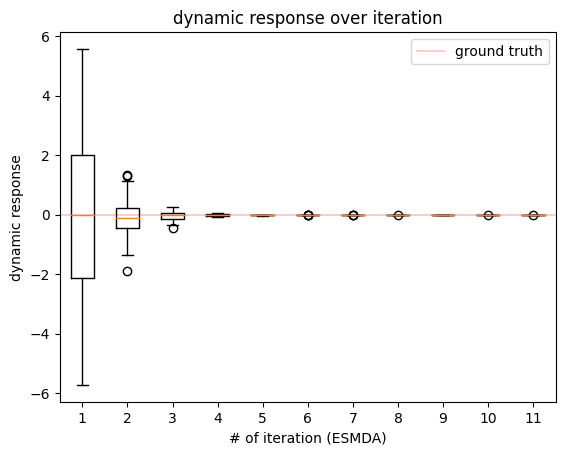

In [71]:
# visual - dynamic response of ensemble
response_by_iteration = [forward(ensemble) for ensemble in ensemble_by_iteration]
response_by_iteration = np.array(response_by_iteration)

plt.figure()
plt.title("dynamic response over iteration")
plt.boxplot(response_by_iteration.T);
plt.xlabel('# of iteration (ESMDA)')
plt.ylabel('dynamic response')
plt.axhline(y = 0, color = 'r', linestyle = '-', alpha = 0.2, label = 'ground truth')
plt.legend()
